In [1]:
%load_ext autoreload
%autoreload 2

test_path = "../Datasets/Padchest_Occlusion/Images"

In [2]:
import sys 
sys.path.append('..')

In [3]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

import pathlib
import re

from utils.dataLoader import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

device = 'cuda:0'

In [4]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 6
config['l2'] = 5

double65 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
double65.load_state_dict(torch.load("../weights_extended/double_65_ext/bestMSE.pt"))
double65.eval()
print('Model loaded')

6-5
Model loaded


In [5]:
from models.unet import UNet

unet = UNet(n_classes = 3).to(device)
unet.load_state_dict(torch.load('../weights_extended/unet_ext/bestDice.pt'))
unet.eval()

print('Model loaded')

Model loaded


In [6]:
data_root = pathlib.Path(test_path)
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

In [7]:
from medpy.metric import dc, hd, assd, jc
from utils.fun import reverseVector, drawBinary

def evalImageMetrics(blank, output, target):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)

    hdp = hd(ptest, target == 1)
    dcp = dc(ptest, target == 1)
    
    ptest = drawBinary(blank.copy(), h)

    hdc = hd(ptest, target == 2)
    dcc = dc(ptest, target == 2)
    
    return [dcp, hdp, dcc, hdc]

def evalImageMetricsUNet(output, target):
    dcp = dc(output == 1, target == 1)
    dcc = dc(output == 2, target == 2)
    
    hdp = hd(output == 1, target == 1)
    hdc = hd(output == 2, target == 2)
    
    return [dcp, hdp, dcc, hdc]

In [8]:
from utils.fun import drawOrgans
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

results = pd.DataFrame()
blank = np.zeros([1024, 1024])

i = 0
for sample in all_files:
    with torch.no_grad():
        img = cv2.imread(sample, 0) / 255
        data = np.expand_dims(img, axis = 0)
        data = np.expand_dims(data, axis = 0)
        data = torch.tensor(data).to(device).float()
        
        gt = cv2.imread(sample.replace('Images','Masks'), cv2.IMREAD_UNCHANGED)
        
        output = double65(data)
        if len(output) > 1:
            output = output[0]
            
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]
        
        metrics = evalImageMetrics(blank, output * 1024, gt)
             
        aux = pd.DataFrame([['HybridGNet 2-IGSC'] + metrics[:2] + ['Lungs']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        aux = pd.DataFrame([['HybridGNet 2-IGSC'] + metrics[2:] + ['Heart']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        
        output = unet(data)
        output = torch.argmax(output[0,:,:,:], axis=0).cpu().numpy()
        
        metrics = evalImageMetricsUNet(output, gt)
        
        aux = pd.DataFrame([['UNet'] + metrics[:2] + ['Lungs']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        aux = pd.DataFrame([['UNet'] + metrics[2:] + ['Heart']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)

        i = i+1

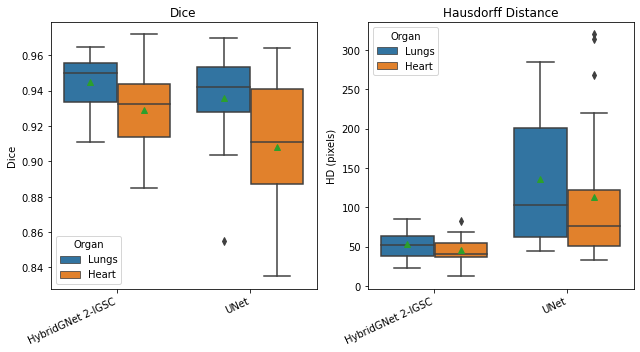

In [9]:
import seaborn as sns

plt.figure(figsize = (9,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice', data = results, hue = 'Organ', showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD', data = results, hue = 'Organ', showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (pixels)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
plt.savefig('figs/real_oc_1.png', dpi=200, bbox_inches="tight")
plt.savefig('figs/real_oc_1.pdf', dpi=200, bbox_inches="tight")
plt.show()

In [10]:
from scipy.stats import wilcoxon

model1 = "HybridGNet 2-IGSC"
model2 = "UNet"

mse1 = results[results['Model'] == model1]
mse1 = mse1[mse1['Organ'] == "Lungs"]['Dice']
mse2 = results[results['Model'] == model2]
mse2 = mse2[mse2['Organ'] == "Lungs"]['Dice']

pvalue = wilcoxon(mse1, mse2)
print('Dice Lungs: p-value:', pvalue[1])

mse1 = results[results['Model'] == model1]
mse1 = mse1[mse1['Organ'] == "Heart"]['Dice']
mse2 = results[results['Model'] == model2]
mse2 = mse2[mse2['Organ'] == "Heart"]['Dice']

pvalue = wilcoxon(mse1, mse2)
print('Dice Heart: p-value:', pvalue[1])

model1 = "HybridGNet 2-IGSC"
model2 = "UNet"

mse1 = results[results['Model'] == model1]
mse1 = mse1[mse1['Organ'] == "Lungs"]['HD']
mse2 = results[results['Model'] == model2]
mse2 = mse2[mse2['Organ'] == "Lungs"]['HD']

pvalue = wilcoxon(mse1, mse2)
print('HD Lungs: p-value:', pvalue[1])

mse1 = results[results['Model'] == model1]
mse1 = mse1[mse1['Organ'] == "Heart"]['HD']
mse2 = results[results['Model'] == model2]
mse2 = mse2[mse2['Organ'] == "Heart"]['HD']

pvalue = wilcoxon(mse1, mse2)
print('HD Heart: p-value:', pvalue[1])

Dice Lungs: p-value: 0.16495704650878906
Dice Heart: p-value: 0.00365447998046875
HD Lungs: p-value: 6.29425048828125e-05
HD Heart: p-value: 9.5367431640625e-06


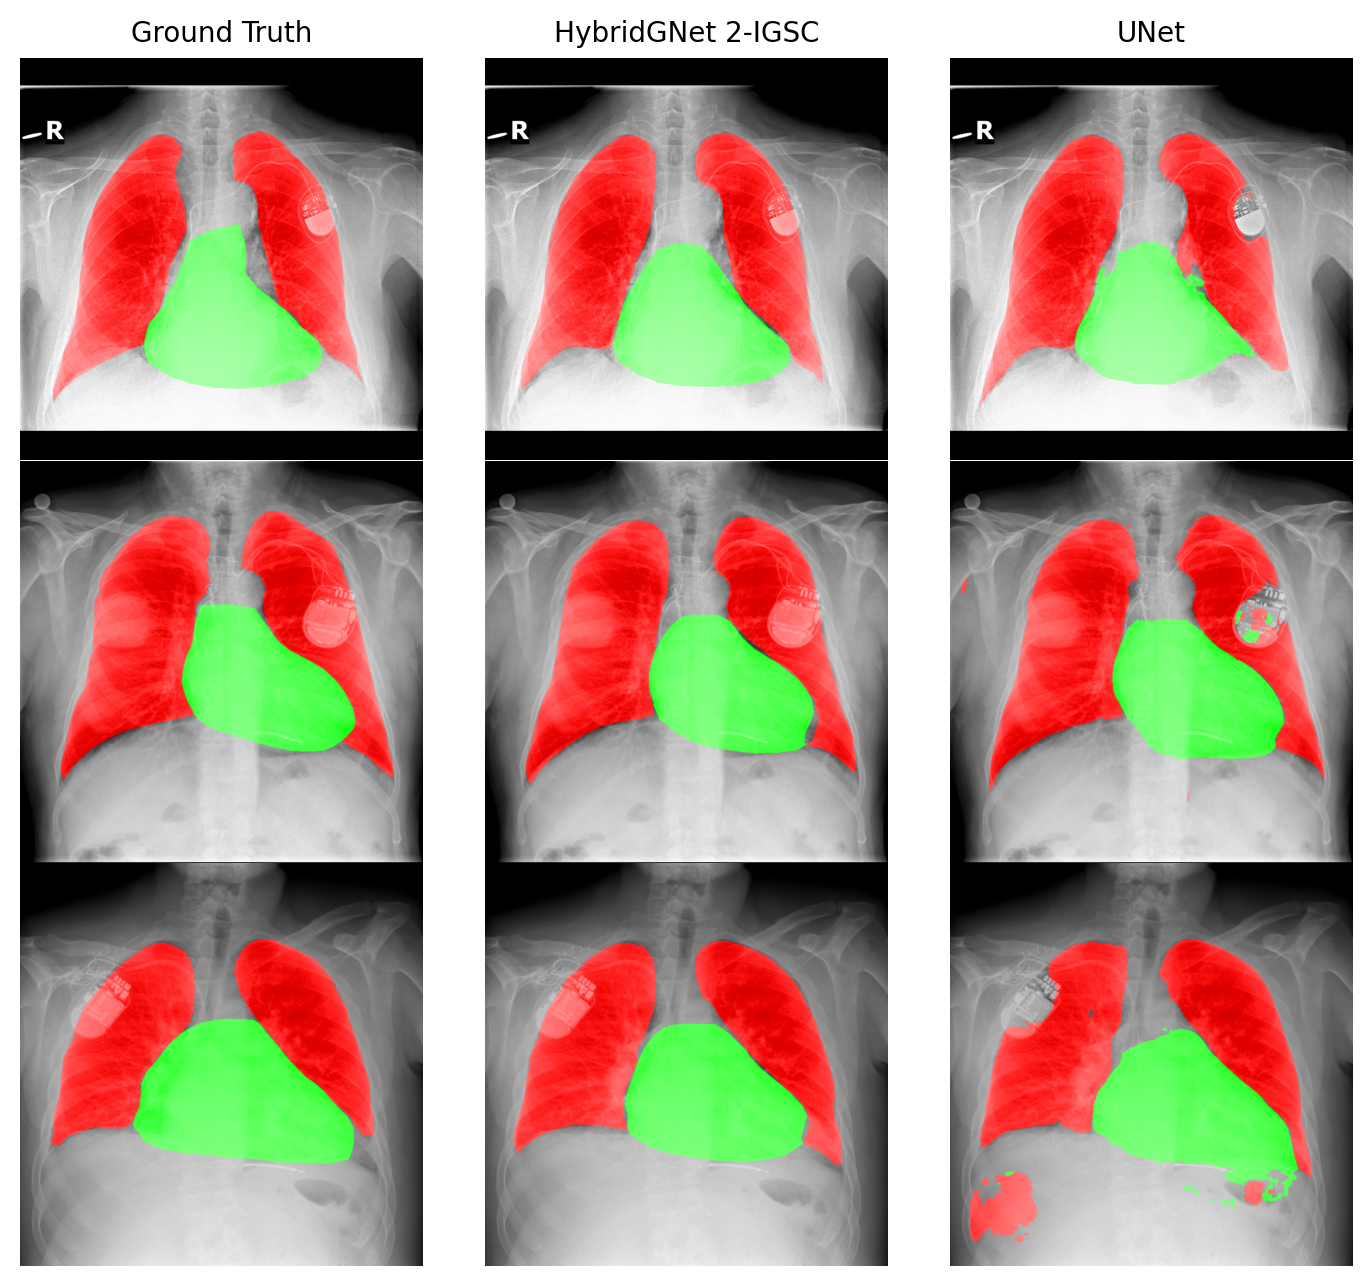

In [12]:
indx = [1,4,8]

plt.figure(figsize = (9,8), dpi = 200)

for j in range(0,3):
    sample=all_files[indx[j]]
    with torch.no_grad():
        img = cv2.imread(sample, 0) / 255
        data = np.expand_dims(img, axis = 0)
        data = np.expand_dims(data, axis = 0)
        data = torch.tensor(data).to(device).float()

        ax = plt.subplot(3, 3, 1 + j*3)
        plt.axis('off')
        
        gt = cv2.imread(sample.replace('Images','Masks'), cv2.IMREAD_UNCHANGED)

        draw = img
        image = np.zeros(list(draw.shape) + [3])
        image[:,:,0] = draw + 0.7 * (gt == 1).astype('float') - 0.3 * (gt == 2).astype('float')
        image[:,:,1] = draw + 0.7 * (gt == 2).astype('float') - 0.2 * (gt == 1).astype('float')
        image[:,:,2] = draw - 0.2 * (gt == 1).astype('float') - 0.3 * (gt == 2).astype('float')
        image = np.clip(image, 0, 1)

        if j==0:
            plt.title('Ground Truth', fontsize=10)
        plt.imshow(image)
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        
        ax = plt.subplot(3, 3, 2 + j*3)
        plt.axis('off')
                         
        output = double65(data)
        if len(output) > 1:
            output = output[0]
            
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]
        
        p1, p2, h, c1, c2 = reverseVector(output * 1024)
    
        lungs = drawBinary(blank.copy(), p1) 
        lungs = drawBinary(lungs, p2) / 255
        heart = drawBinary(blank.copy(), h) / 255
        
        output = lungs + 2 * heart
        
        image = np.zeros(list(draw.shape) + [3])
        image[:,:,0] = draw + 0.7 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image[:,:,1] = draw + 0.7 * (output == 2).astype('float') - 0.2 * (output == 1).astype('float')
        image[:,:,2] = draw - 0.2 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image = np.clip(image, 0, 1)

        if j==0:
            plt.title('HybridGNet 2-IGSC', fontsize=10)
        plt.imshow(image)
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)

        ax = plt.subplot(3, 3, 3 + j*3)
        plt.axis('off')

        output = unet(data)
        output = torch.argmax(output[0,:,:,:], axis=0).cpu().numpy()
        
        image = np.zeros(list(draw.shape) + [3])
        image[:,:,0] = draw + 0.7 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image[:,:,1] = draw + 0.7 * (output == 2).astype('float') - 0.2 * (output == 1).astype('float')
        image[:,:,2] = draw - 0.2 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image = np.clip(image, 0, 1)
        
        if j==0:
            plt.title('UNet', fontsize=10)
            
        plt.imshow(image)
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figs/real_oc_2.png', bbox_inches= 'tight', dpi = 200)
plt.savefig('figs/real_oc_2.pdf', bbox_inches= 'tight', dpi = 200)